## Load the data

In [1]:
using DataDrop

In [2]:
P_max = DataDrop.retrieve_matrix("PTDF_data/P_max_gen.h5");

In [3]:
P_total = DataDrop.retrieve_matrix("PTDF_data/P_total.h5");

In [4]:
A_constraints = DataDrop.retrieve_matrix("PTDF_data/A_gen_total.h5");

In [5]:
P_constraints = DataDrop.retrieve_matrix("PTDF_data/gen_total.h5");

In [6]:
A_ramp = DataDrop.retrieve_matrix("PTDF_data/A_gen_ramp.h5");

In [7]:
ΔP_ramp = DataDrop.retrieve_matrix("PTDF_data/gen_ramp.h5");

In [8]:
L_lines = DataDrop.retrieve_matrix("PTDF_data/linear_line_cost.h5");

In [9]:
L_gens = DataDrop.retrieve_matrix("PTDF_data/linear_gen_cost.h5");

In [10]:
Q = DataDrop.retrieve_matrix("PTDF_data/quadratic_cost.h5");

## Computation

In [11]:
import MathOptInterface as MOI

In [12]:
using Gurobi

const gurobi_env = Gurobi.Env();

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-17


In [13]:
optimizer = MOI.instantiate(MOI.OptimizerWithAttributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    sense  : minimize
    number of variables             = 0
    number of linear constraints    = 0
    number of quadratic constraints = 0
    number of sos constraints       = 0
    number of non-zero coeffs       = 0
    number of non-zero qp objective terms  = 0
    number of non-zero qp constraint terms = 0


In [14]:
# optimizer = Gurobi.Optimizer(gurobi_env)

In [15]:
function opf(Q::AbstractArray{<:Real,2}, L::AbstractArray{<:Real,2}, 
        P_max::AbstractVector{<:Real}, P_total::AbstractVector{<:Real},
        A_constraints::AbstractArray{<:Real,2}, P_constraints::AbstractVector{<:Real},
        A_ramp::AbstractArray{<:Real,2} = Array{Real}(undef, 0, 0), ΔP_ramp_max::AbstractVector{<:Real} = Real[],
        P_ramp_first::AbstractVector{<:Real} = Real[], P_ramp_last::AbstractVector{<:Real} = Real[];
        indent::Int = 0)

    N = length(P_max)
    T = length(P_total)
    n_constraints = length(P_constraints)
    n_ramp = length(ΔP_ramp)

    # check dimensions of the input
    @assert size(Q) == (N, N)
    @assert size(L) == (N, T)
    @assert size(A_constraints) == (n_constraints, N)
    @assert (size(A_ramp) == (n_ramp, N)) || (n_ramp == 0)
    @assert length(P_ramp_first) ∈ [0, n_ramp]
    @assert length(P_ramp_last) == length(P_ramp_first)
    
    print(" "^indent)
    print("OPF with $T time steps, $N generators, $n_constraints annual constraints")
    if n_ramp > 0
        if length(P_ramp_first) == 0
            print(", and $n_ramp ramp constraints (cyclic)")
        else
            print(", and $n_ramp ramp constraints (fixed boundaries)")
        end
    end
    println()
    
    # check feasibility of the model
    print(" "^indent)
    println("Checking model...")
    flush(stdout)
    @assert all(P_constraints .<= A_constraints * P_max)
    @assert all(ΔP_ramp .>= 0)
    @assert all(P_total .<= sum(P_max))

    # variables
    print(" "^indent)
    println("Defining variables...")
    flush(stdout)
    P_vec = MOI.add_variables(optimizer, N * T)
    P = reshape(P_vec, (N, T))

    # constraints 
    print(" "^indent)
    println("Defining constraints...")
    flush(stdout)
    MOI.add_constraints(optimizer, P_vec, [MOI.Interval(0.0, P_max[i]) for t = 1:T for i = 1:N])

    MOI.add_constraints(optimizer,
        [MOI.ScalarAffineFunction([MOI.ScalarAffineTerm(1.0, P[i,t]) for i = 1:N], 0.0) for t = 1:T],
        [MOI.EqualTo(P_total[t]) for t = 1:T])
    MOI.add_constraints(optimizer,
        A_constraints * [MOI.ScalarAffineFunction([MOI.ScalarAffineTerm(1.0 / T, P[i,t]) for t = 1:T], 0.0) for i = 1:N],
        [MOI.EqualTo(P_constraints[n]) for n = 1:n_constraints])
    
    if n_ramp > 0
        P_ramp = A_ramp * P
        if length(P_ramp_first) == 0
            ΔP = [P_ramp[n, t] - P_ramp[n, t % T + 1] for t = 1:T for n = 1:n_ramp]
            MOI.add_constraints(optimizer, ΔP, [MOI.GreaterThan(-ΔP_ramp[n]) for t = 1:T for n = 1:n_ramp])
            MOI.add_constraints(optimizer, ΔP, [MOI.LessThan(ΔP_ramp[n]) for t = 1:T for n = 1:n_ramp])
        else
            ΔP = [P_ramp[n, t] - P_ramp[n, t + 1] for t = 1:T-1 for n = 1:n_ramp]
            MOI.add_constraints(optimizer, ΔP, [MOI.GreaterThan(-ΔP_ramp[n]) for t = 1:T-1 for n = 1:n_ramp])
            MOI.add_constraints(optimizer, ΔP, [MOI.LessThan(ΔP_ramp[n]) for t = 1:T-1 for n = 1:n_ramp])
            P_first = [P_ramp[n, 1] for n = 1:n_ramp]
            MOI.add_constraints(optimizer, P_first, [MOI.GreaterThan(P_ramp_first[n] - ΔP_ramp[n]) for n = 1:n_ramp])
            MOI.add_constraints(optimizer, P_first, [MOI.LessThan(P_ramp_first[n] + ΔP_ramp[n]) for n = 1:n_ramp])
            P_last = [P_ramp[n, T] for n = 1:n_ramp]
            MOI.add_constraints(optimizer, P_last, [MOI.GreaterThan(P_ramp_last[n] - ΔP_ramp[n]) for n = 1:n_ramp])
            MOI.add_constraints(optimizer, P_last, [MOI.LessThan(P_ramp_last[n] + ΔP_ramp[n]) for n = 1:n_ramp])
        end
    end
    
    print(" "^indent)
    println("Computing objective function...")
    flush(stdout)
    quadratic_terms = vcat(
        [MOI.ScalarQuadraticTerm(2.0 * Q[i,i], P[i, t], P[i, t]) for i = 1:N for t = 1:T],
        [MOI.ScalarQuadraticTerm(Q[i,j], P[i, t], P[j, t]) for i = 1:N for j = (i+1):N for t = 1:T]
    )
    affine_terms = [MOI.ScalarAffineTerm(L[i, t], P[i, t]) for i = 1:N for t = 1:T]
    objective = MOI.ScalarQuadraticFunction(quadratic_terms, affine_terms, 0.0)
    
    MOI.set(optimizer, MOI.ObjectiveFunction{MOI.ScalarQuadraticFunction{Float64}}(), objective)
    MOI.set(optimizer, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    
    print(" "^indent)
    println("Optimizing...")
    flush(stdout)
    MOI.optimize!(optimizer)
    
    print(" "^indent)
    println("Exporting results...")
    flush(stdout)
    P_vec_solution = MOI.get(optimizer, MOI.VariablePrimal(), P_vec)
    P_vec_solution = map(x -> isapprox(x, 0, atol=1e-6) ? 0.0 : x, P_vec_solution)
    P_solution = reshape(P_vec_solution, (N, T))
    
    return P_solution
end

opf (generic function with 5 methods)

In [16]:
function partitioned_opf(partitions::Vector{Int},
        Q::AbstractArray{<:Real,2}, L_lines::AbstractArray{<:Real,2}, L_gens::AbstractArray{<:Real,2}, 
        P_max::AbstractVector{<:Real}, P_total::AbstractVector{<:Real},
        A_constraints::AbstractArray{<:Real,2}, P_constraints::AbstractVector{<:Real},
        A_ramp::AbstractArray{<:Real,2} = Array{Real}(undef, 0, 0), ΔP_ramp_max::AbstractVector{<:Real} = Real[],
        P_ramp_first::AbstractVector{<:Real} = Real[], P_ramp_last::AbstractVector{<:Real} = Real[];
        indent::Int = 0)
    
    N = length(P_max)
    T = length(P_total)
    n_constraints = length(P_constraints)
    n_ramp = length(ΔP_ramp_max)

    # check that the number of partitions matches the total number of steps
    @assert prod(partitions) == T

    if length(partitions) == 1
        return opf(Q, L_lines + L_gens, P_max, P_total, A_constraints, P_constraints,
            A_ramp, ΔP_ramp_max, P_ramp_first, P_ramp_last, indent = indent + 4)
    end

    # check dimensions of the input that needs to be partitioned
    @assert size(L_lines) == (N, T)
    @assert size(L_gens) == (N, T)
    @assert size(A_constraints) == (n_constraints, N)
    @assert (size(A_ramp) == (n_ramp, N)) || (n_ramp == 0)

    n_partitions = partitions[1]
    partition_length = T ÷ n_partitions
    
    println()
    print(" "^indent)
    println(">>> Partitioning a dataset of $T time steps into $n_partitions chunks of $partition_length time steps")
    println()

    partitioned_P_total = reshape(P_total, (partition_length, n_partitions))
    aggregated_P_total = dropdims(sum(partitioned_P_total, dims=1), dims=1) / partition_length

    partitioned_L_lines = reshape(L_lines, (N, partition_length, n_partitions))
    aggregated_L_lines = dropdims(sum(partitioned_L_lines, dims=2), dims=2) / partition_length

    partitioned_L_gens = reshape(L_gens, (N, partition_length, n_partitions))
    
    aggregated_P = opf(Q, aggregated_L_lines, P_max, aggregated_P_total, A_constraints, P_constraints,
        A_ramp, ΔP_ramp_max, P_ramp_first, P_ramp_last, indent = indent + 4)

    aggregated_P = min.(aggregated_P, P_max)
    partitioned_P_constraints = A_constraints * aggregated_P
    partitioned_P_ramp = n_ramp > 0 ? A_ramp * aggregated_P : Real[]

    result = Matrix{Float64}(undef, N, 0)
    timing = []
    for a=1:n_partitions
        println()
        print(" "^indent)
        print(">>> Step $a of $n_partitions")
        if length(timing) > 0
            print(" (estimated remaining time:")
            s = round(Int, (n_partitions - a + 1) * sum(timing) / length(timing))
            if s >= 60
                m = s ÷ 60
                s = s % 60
                if m >= 60
                    h = m ÷ 60
                    m = m % 60
                    print(" $h h")
                end
                print(" $m min")
            end
            print(" $s s)")
        end
        println()
        
        if n_ramp == 0
            partitioned_P_ramp_previous = Real[]
            partitioned_P_ramp_next = Real[]
        else
            if a == 1
                partitioned_P_ramp_previous = length(P_ramp_first) > 0 ? P_ramp_first : partitioned_P_ramp[:, end]
            else
                partitioned_P_ramp_previous = partitioned_P_ramp[:, a - 1]
            end
            if a == n_partitions
                partitioned_P_ramp_next = length(P_ramp_last) > 0 ? P_ramp_last : partitioned_P_ramp[:, 1]
            else
                partitioned_P_ramp_next = partitioned_P_ramp[:, a + 1]
            end
        end
        
        partition_result = @timed partitioned_opf(partitions[2:end], Q, partitioned_L_lines[:,:,a], partitioned_L_gens[:,:,a],
            P_max, partitioned_P_total[:,a], A_constraints, partitioned_P_constraints[:,a],
            A_ramp, ΔP_ramp_max, partitioned_P_ramp_previous, partitioned_P_ramp_next, indent = indent + 4)
        push!(timing, partition_result.time)
        result = hcat(result, partition_result.value)
    end

    return result
end

partitioned_opf (generic function with 5 methods)

In [17]:
P_total_reduced = dropdims(sum(reshape(P_total, (728, 12)), dims=1), dims=1) ./ 728
L_lines_reduced = dropdims(sum(reshape(L_lines, (1039, 728, 12)), dims=2), dims=2) ./ 728
L_gens_reduced = dropdims(sum(reshape(L_gens, (1039, 728, 12)), dims=2), dims=2) ./ 728;

In [18]:
P_full_1 = opf(Q, L_lines_reduced + L_gens_reduced, P_max, P_total_reduced, A_constraints, P_constraints, A_ramp, ΔP_ramp)

OPF with 12 time steps, 1039 generators, 1038 annual constraints, and 167 ramp constraints (cyclic)
Checking model...
Defining variables...
Defining constraints...
Computing objective function...
Optimizing...
Exporting results...


1039×12 Matrix{Float64}:
 0.449752   0.410623   0.406749   …  0.0248671   0.334142    0.730225
 1.13188    0.711761   0.328522      0.15978     0.636711    0.686395
 0.321183   0.257972   0.218259      0.0         0.00540912  0.257099
 0.291655   0.152595   0.0812398     0.0         0.0         0.199039
 0.259116   0.185685   0.0257118     0.0         0.0         0.121279
 0.0        0.0        0.0        …  0.0         0.0         0.0
 0.0        0.0        0.151347      0.0         0.0         0.0
 3.17992    2.80953    2.17109       1.45338     2.82719     2.56495
 1.59421    1.67663    1.67295       1.06055     0.96531     1.38222
 2.88205    2.85542    2.54889       1.49296     2.1202      2.53649
 2.07905    2.01901    1.60439    …  0.0         0.0         0.0
 0.0        0.0        0.0           0.0         0.0         0.0
 0.0        0.0        0.0           0.0         0.0         0.0
 ⋮                                ⋱              ⋮           
 0.0        0.0        0.0     

In [19]:
P_partitioned_1 = partitioned_opf([3, 4], Q, L_lines_reduced, L_gens_reduced,
    P_max, P_total_reduced, A_constraints, P_constraints, A_ramp, ΔP_ramp)


>>> Partitioning a dataset of 12 time steps into 3 chunks of 4 time steps

    OPF with 3 time steps, 1039 generators, 1038 annual constraints, and 167 ramp constraints (cyclic)
    Checking model...
    Defining variables...
    Defining constraints...
    Computing objective function...
    Optimizing...
    Exporting results...

>>> Step 1 of 3
        OPF with 4 time steps, 1039 generators, 1038 annual constraints, and 167 ramp constraints (fixed boundaries)
        Checking model...
        Defining variables...
        Defining constraints...
        Computing objective function...
        Optimizing...
        Exporting results...

>>> Step 2 of 3 (estimated remaining time: 50 s)
        OPF with 4 time steps, 1039 generators, 1038 annual constraints, and 167 ramp constraints (fixed boundaries)
        Checking model...
        Defining variables...
        Defining constraints...
        Computing objective function...
        Optimizing...
        Exporting results...

>>> St

1039×12 Matrix{Float64}:
 0.566535     0.522855     0.521655    …  0.0        0.130223   0.533727
 1.22818      0.806073     0.424303       0.0386619  0.525583   0.68911
 0.336139     0.272065     0.232797       0.0        0.0        0.171905
 0.333479     0.193821     0.123375       0.0        0.0        0.0696793
 0.173359     0.0913977    0.00235583     0.0        0.0        0.140147
 0.000507771  0.00544048   0.00165932  …  0.0        0.0        0.0
 0.00085989   0.000898234  0.171798       0.0        0.0359832  0.00474986
 3.18684      2.81595      2.20669        1.3951     2.78685    2.53908
 1.44136      1.52307      1.54843        1.08428    1.00698    1.43837
 2.66725      2.64006      2.36287        1.64436    2.28955    2.72031
 1.40486      1.34313      0.95817     …  0.0        0.622989   0.0
 0.0          0.0          0.0            0.0        0.0        0.0
 0.0          0.0          0.0            0.0        0.0        0.0
 ⋮                                     ⋱       

In [20]:
P_full_0 = opf(Q, L_lines_reduced + 0 * L_gens_reduced, P_max, P_total_reduced, A_constraints, P_constraints, A_ramp, ΔP_ramp)

OPF with 12 time steps, 1039 generators, 1038 annual constraints, and 167 ramp constraints (cyclic)
Checking model...
Defining variables...
Defining constraints...
Computing objective function...
Optimizing...
Exporting results...


1039×12 Matrix{Float64}:
 0.798952   0.645589   0.237663    …  0.0        0.267832     0.486116
 1.0357     0.789203   0.506822       0.0118254  0.439488     0.727782
 0.393582   0.265111   0.129817       0.0        0.0627528    0.211379
 0.325329   0.196511   0.0269149      0.0        0.010409     0.165364
 0.066363   0.0606776  0.0879028      0.0226495  0.0          0.0601233
 0.1036     0.0387835  0.0         …  0.0        0.0          0.0103218
 0.0445141  0.0371959  0.0607638      0.0        0.0          0.0367818
 2.86746    2.68459    2.46481        2.08599    2.28237      2.68313
 1.67672    1.49385    1.27407        0.895246   1.09163      1.49239
 2.78161    2.59874    2.37896        2.00013    2.19652      2.59728
 1.61941    1.25671    0.768406    …  0.147607   0.536804     1.10913
 0.0        0.0        0.0            0.0        0.0          0.0
 0.0        0.0        0.0            0.0        0.0          0.0
 ⋮                                 ⋱             ⋮            


In [21]:
P_partitioned_0 = partitioned_opf([3, 4], Q, L_lines_reduced, 0 * L_gens_reduced,
    P_max, P_total_reduced, A_constraints, P_constraints, A_ramp, ΔP_ramp)


>>> Partitioning a dataset of 12 time steps into 3 chunks of 4 time steps

    OPF with 3 time steps, 1039 generators, 1038 annual constraints, and 167 ramp constraints (cyclic)
    Checking model...
    Defining variables...
    Defining constraints...
    Computing objective function...
    Optimizing...
    Exporting results...

>>> Step 1 of 3
        OPF with 4 time steps, 1039 generators, 1038 annual constraints, and 167 ramp constraints (fixed boundaries)
        Checking model...
        Defining variables...
        Defining constraints...
        Computing objective function...
        Optimizing...
        Exporting results...

>>> Step 2 of 3 (estimated remaining time: 1 min 17 s)
        OPF with 4 time steps, 1039 generators, 1038 annual constraints, and 167 ramp constraints (fixed boundaries)
        Checking model...
        Defining variables...
        Defining constraints...
        Computing objective function...
        Optimizing...
        Exporting results...



1039×12 Matrix{Float64}:
 0.830849    0.672626    0.265229    …  0.0        0.221919   0.442031
 1.03691     0.787937    0.505406       0.0        0.466202   0.786747
 0.427597    0.298128    0.162805       0.0        0.0        0.171905
 0.360499    0.231098    0.0624068      0.0        0.0        0.0696791
 0.0667206   0.0605057   0.0862911      0.0210345  0.0        0.0642169
 0.0958876   0.0377669   0.0126874   …  0.0        0.0        0.0
 0.0464871   0.0396704   0.0600459      0.0        0.0        0.0294777
 2.86735     2.68397     2.46401        2.08578    2.28313    2.68458
 1.6765      1.49311     1.27328        0.895037   1.09239    1.49384
 2.78138     2.59808     2.37817        1.99992    2.19728    2.59873
 1.61716     1.25316     0.765434    …  0.147062   0.538775   1.11286
 0.0         0.0         0.0            0.0        0.0        0.0
 0.0         0.0         0.0            0.0        0.0        0.0
 ⋮                                   ⋱             ⋮          
 0.0 

Comparison

In [24]:
using Plots

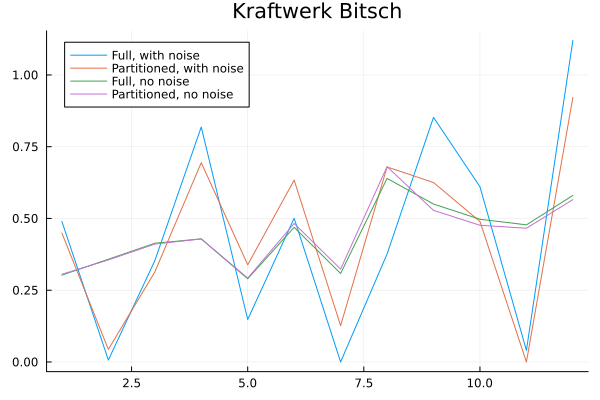

In [26]:
plot(P_full_1[877, :], label="Full, with noise", title="Kraftwerk Bitsch")
plot!(P_partitioned_1[877, :], label="Partitioned, with noise")
plot!(P_full_0[877, :], label="Full, no noise")
plot!(P_partitioned_0[877, :], label="Partitioned, no noise")

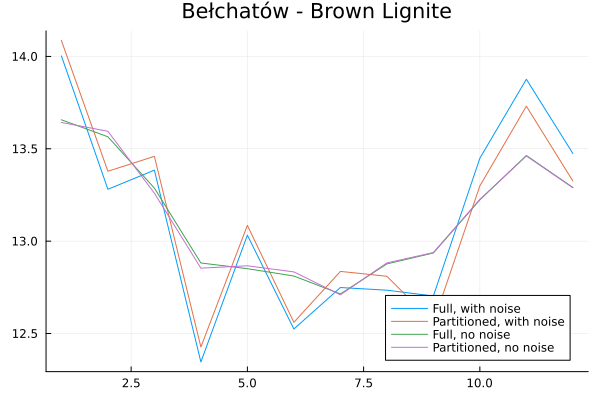

In [28]:
plot(P_full_1[312, :], label="Full, with noise", title="Bełchatów - Brown Lignite")
plot!(P_partitioned_1[312, :], label="Partitioned, with noise")
plot!(P_full_0[312, :], label="Full, no noise")
plot!(P_partitioned_0[312, :], label="Partitioned, no noise")

Check that the total production for all generators is the same in all cases:

In [44]:
[maximum(abs.(sum(P, dims=2) - sum(P_full_1, dims=2))) for P ∈ [P_full_0, P_partitioned_0, P_partitioned_1]]

3-element Vector{Float64}:
 2.7993897194211748e-6
 6.710352494110339e-5
 7.242102614668511e-5

Possible partitions:

In [22]:
52 * 168, 26 * 336, 13 * 672, 8 * 1092, 4 * 2184

(8736, 8736, 8736, 8736, 8736)